In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import openai
from tenacity import retry, stop_after_attempt, wait_random_exponential

from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch

import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv("Data/web_questions.csv")
df.head()

,question,answers
0,what currency does senegal use?,['West African CFA franc']
1,what type of money does jamaica use?,['Jamaican dollar']
2,what money to take to sri lanka?,['Sri Lankan rupee']
3,when did the charlotte bobcats first play in t...,['2004 NBA Draft']
4,where is north port florida located?,['Sarasota County' 'United States of America' ...


In [23]:
df['answers'] = df['answers'].apply(lambda x: x.strip("[]'"))
df.to_csv("Data/web_questions.csv", index=False)
df.head()

,question,answers
0,what currency does senegal use?,West African CFA franc
1,what type of money does jamaica use?,Jamaican dollar
2,what money to take to sri lanka?,Sri Lankan rupee
3,when did the charlotte bobcats first play in t...,2004 NBA Draft
4,where is north port florida located?,Sarasota County' 'United States of America' 'F...


In [24]:
# df with translated question_arm column
df = pd.read_csv("Data/web_questions.csv")
df.head()

,question,answers,question_arm
0,what currency does senegal use?,West African CFA franc,ինչ արժույթ է օգտագործում Սենեգալը:
1,what type of money does jamaica use?,Jamaican dollar,ինչ տեսակի փող է օգտագործում Ջամայկան:
2,what money to take to sri lanka?,Sri Lankan rupee,ինչ գումար տանել Շրի Լանկա.
3,when did the charlotte bobcats first play in t...,2004 NBA Draft,Ե՞րբ են charlotte bobcats-ն առաջին անգամ խաղաց...
4,where is north port florida located?,Sarasota County' 'United States of America' 'F...,որտեղ է գտնվում Հյուսիսային Պորտ Ֆլորիդան:


In [32]:
# Read the API key from the file
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

# Set the API key in the OpenAI library
openai.api_key = api_key

# Define the model to use
GPT_MODEL = "gpt-3.5-turbo-0613"

In [33]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model = GPT_MODEL):
    """
    Sends request to the OpenAI API to generate chat completions based on the provided messages.

    Parameters:
    - messages (list): A list of message dictionaries to be sent to the chat completion model.
    - tools (list, optional): A list of tools that can be utilized for generating completions.
    - tool_choice (str, optional): A specific tool choice to influence the completion generation.
    - model (str): The model to be used for generating completions.

    Returns:
    - dict: The JSON response from the API containing the completion if the request is successful.

    Raises:
    - Exception: If the request fails after the maximum number of retry attempts, it raises and
      returns the exception, and prints an error message to the console.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}

    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
        
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response.json() 
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

# Zero-Shot Prompting

In [39]:
def zero_shot_question(question, language = "English"):
    """
    This function asks a zero-shot question based on the provided question.
    
    Args:
    question (str): The question to ask.
    
    Returns:
    str: The answer generated by the model.
    """
    messages = []
    messages.append({
        "role": "system",
        "content": f"Answer the given question in {language}. Provide a short, precise and direct responses based on your knowledge."
    })
    messages.append({
        "role": "assistant",
        "content": question
    })
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message


In [38]:
# Example
question = """որտեղ է գտնվում Հյուսիսային Պորտ Ֆլորիդան:"""
response = zero_shot_question(question, language="Armenian")
print(response)

Հյուսիսային Պորտ Ֆլորիդան գտնվում է ԱՄՆ-ի Ֆլորիդա նահանգում:


In [41]:
def apply_zero_shot_to_df(df, question_col, response_col, language="English"):
    """
    Applies zero-shot question answering to specified question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = zero_shot_question(row[question_col], language)
        df.at[index, response_col] = response

    
    # Save the DataFrame after updating
    df.to_csv('Data/web_questions.csv', index=False)

In [44]:
apply_zero_shot_to_df(df, 'question', 'response_en_ZS')
apply_zero_shot_to_df(df, 'question_arm', 'response_arm_ZS', language='Armenian')

# One-Shot Prompting

In [64]:
def one_shot_question(question, example, language="English"):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - question (str): The question that needs answering.
    - example (dict): An example containing a question and answer to guide the model.
    - language (str): The language in which the question is written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": f"Answer the given question in {language}. Provide a short, precise, and direct response based on your knowledge."},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [65]:
def apply_one_shot_to_df(df, question_col, example, response_col, language="English"):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - example (dict): The example to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions, passages, and examples are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = one_shot_question(row[question_col], example, language)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/web_questions.csv', index=False)


In [69]:
example_en = {
    "question": "What is the largest rainforest in the world?",
    "answer": "The Amazon Rainforest."
}

example_arm = {
    "question" : "Ո՞րն է աշխարհի ամենամեծ անձրևային անտառը:",
    "answer": "Ամազոնի անձրևային անտառ:"
}

In [67]:
apply_one_shot_to_df(df, 'question', example_en, 'response_en_OS')
apply_one_shot_to_df(df, 'question_arm', example_arm, 'response_arm_OS', language = "Armenian")

# Few-Shot Prompting

In [76]:
def few_shot_question(question, few_shot_examples, language="English"):
    """
    Executes a few-shot learning-based question answering with multiple examples provided, without using a passage.

    Parameters:
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and an answer to guide the model.
    - language (str): The language in which the questions are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": f"Answer the given question in {language}. Use the examples provided to guide your response, which should be direct, short, and precise."}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    messages.append({"role": "assistant", "content": question})
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    
    return assistant_message

In [77]:
def apply_few_shot_to_df(df, question_col, few_shot_examples, response_col, language="English"):
    """
    Applies few-shot question answering to specified question column of a DataFrame,
    using a list of examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and answer.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are written. Defaults to "English".

    Returns:
    - pandas.DataFrame: The updated DataFrame with responses added in a new column.
    """
   
    for index, row in df.iterrows():
        response = few_shot_question(row[question_col], few_shot_examples, language)
        df.at[index, response_col] = response

    df.to_csv('Data/web_questions.csv', index=False)

In [78]:
few_shot_examples_en = [
    {"question": "What is the largest island in the world?", "answer": "Greenland"},
    {"question": "What is the main language spoken in China?", "answer": "The main language spoken in China is Mandarin."},
    {"question": "Who is the author of the novel 1984?", "answer": "The author of the novel 1984 is George Orwell."}
]

few_shot_examples_arm = [
    {"question": "Ո՞րն է աշխարհի ամենամեծ կղզին:", "answer": "Գրենլանդիա"},
    {"question": "Ո՞րն է Չինաստանում խոսվող հիմնական լեզուն:", "answer": "Չինաստանում խոսվող հիմնական լեզուն մանդարինն է։"},
    {"question": "Ո՞վ է գրել հայտնի «1984» վեպը։", "answer": "1984 վեպի հեղինակը Ջորջ Օրուելն է։"}
]

In [80]:
apply_few_shot_to_df(df, "question", few_shot_examples_en, "response_en_FS")
apply_few_shot_to_df(df, 'question_arm', few_shot_examples_arm, 'response_arm_FS', language = "Armenian")

# Using Armenian as the language of system_message

## Zero-Shot

In [89]:
def zero_shot_question_arm(question):
    """
    This function asks a zero-shot question based on the provided question.
    
    Args:
    question (str): The question to ask.
    
    Returns:
    str: The answer generated by the model.
    """
    messages = []
    messages.append({
        "role": "system",
        "content": "Կարճ և ճշգրիտ պատասխանիր տրված հարցին, հիմնվելով քո գիտելիքների վրա:"
    })
    messages.append({
        "role": "assistant",
        "content": question
    })
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [90]:
def apply_zero_shot_to_df_arm(df, question_col, response_col):
    """
    Applies zero-shot question answering to specified question columns of a DataFrame,
    and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = zero_shot_question_arm(row[question_col])
        df.at[index, response_col] = response

    
    # Save the DataFrame after updating
    df.to_csv('Data/web_questions.csv', index=False)

In [91]:
apply_zero_shot_to_df_arm(df, 'question_arm', 'response_arm_sys_ZS')

## One-Shot

In [94]:
def one_shot_question_arm(question, example):
    """
    Executes a one-shot learning-based question answering with an example provided.

    Parameters:
    - question (str): The question that needs answering.
    - example (dict): An example containing a question and answer to guide the model.
    - language (str): The language in which the question is written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": "Կարճ և ճշգրիտ պատասխանիր տրված հարցին, հիմնվելով քո գիտելիքների վրա:"},
        {"role": "assistant", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
        {"role": "assistant", "content": question}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    return assistant_message

In [96]:
def apply_one_shot_to_df_arm(df, question_col, example, response_col):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - example (dict): The example to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions, passages, and examples are provided. Defaults to "English".
    """
    for index, row in df.iterrows():
        response = one_shot_question_arm(row[question_col], example)
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/web_questions.csv', index=False)


In [97]:
apply_one_shot_to_df_arm(df, 'question_arm', example_arm, 'response_arm_sys_OS')

## Few-Shot

In [98]:
def few_shot_question_arm(question, few_shot_examples):
    """
    Executes a few-shot learning-based question answering with multiple examples provided, without using a passage.

    Parameters:
    - question (str): The question that needs answering.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and an answer to guide the model.
    - language (str): The language in which the questions are written. Defaults to "English".

    Returns:
    - str: The extracted answer if available; otherwise, an error message.
    """
    messages = [
        {"role": "system", "content": "Կարճ և ճշգրիտ պատասխանիր տրված հարցին, հիմնվելով քո գիտելիքների վրա:"}
    ]

    # Iterate through all provided examples
    for example in few_shot_examples:
        messages.extend([
            {"role": "assistant", "content": example["question"]},
            {"role": "assistant", "content": example["answer"]}
        ])

    messages.append({"role": "assistant", "content": question})
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"] 
    
    return assistant_message

In [99]:
def apply_few_shot_to_df_arm(df, question_col, few_shot_examples, response_col):
    """
    Applies few-shot question answering to specified question column of a DataFrame,
    using a list of examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - few_shot_examples (list of dicts): A list of examples, each containing a question and answer.
    - response_col (str): Name of the column where the responses will be stored.
    - language (str, optional): The language in which the questions are written. Defaults to "English".

    Returns:
    - pandas.DataFrame: The updated DataFrame with responses added in a new column.
    """
   
    for index, row in df.iterrows():
        response = few_shot_question_arm(row[question_col], few_shot_examples)
        df.at[index, response_col] = response

    df.to_csv('Data/web_questions.csv', index=False)

In [100]:
apply_few_shot_to_df_arm(df, 'question_arm', few_shot_examples_arm, 'response_arm_sys_FS')

# Calculating Setence Similarity Using BERT

In [3]:
# Back-translated data using google sheets =GOOGLETRANSLATE() function
# df = pd.read_csv("Data/web_questions.csv")

In [5]:
def calculate_bert_similarity(sentence1, sentence2, tokenizer, model, device):
    """
    Calculate the cosine similarity between two sentences using BERT embeddings.

    Parameters:
    - sentence1 (str): The first sentence.
    - sentence2 (str): The second sentence.

    Returns:
    - float: The cosine similarity score between the two sentence embeddings.
    """
    # Tokenize the sentences
    encodings = tokenizer(
        [sentence1, sentence2], 
        padding=True, 
        return_tensors='pt'
    ).to(device)

    # Generate embeddings with no gradient calculations
    with torch.no_grad():
        outputs = model(**encodings)
        embeddings = outputs.last_hidden_state[:, 0, :]

    # Normalize the embeddings
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute cosine similarity as dot product of normalized embeddings
    similarity = (normalized_embeddings[0] * normalized_embeddings[1]).sum().item() 
    return similarity

In [6]:
def apply_bert_similarity(df, col1, col2, new_col_name):
    """
    Apply BERT-based similarity calculation for two columns in a DataFrame and add results to a new column.

    Parameters:
    - df (DataFrame): The DataFrame containing the text columns.
    - col1 (str): Column name for the first set of sentences.
    - col2 (str): Column name for the second set of sentences.
    - new_col_name (str): Column name for the similarity scores.
    """
    # Load the BERT model and tokenizer
    bert_version = 'bert-large-uncased'
    tokenizer = BertTokenizer.from_pretrained(bert_version)
    model = BertModel.from_pretrained(bert_version)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Calculate similarities and add to DataFrame
    df[new_col_name] = df.apply(lambda row: calculate_bert_similarity(row[col1], row[col2], tokenizer, model, device), axis=1)

In [ ]:
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_ZS_BT', "sim_response_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_OS_BT', "sim_response_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_FS_BT', "sim_response_FS")
apply_bert_similarity(df, 'response_en_ZS', 'response_arm_sys_ZS_BT', "sim_response_arm_sys_ZS")
apply_bert_similarity(df, 'response_en_OS', 'response_arm_sys_OS_BT', "sim_response_arm_sys_OS")
apply_bert_similarity(df, 'response_en_FS', 'response_arm_sys_FS_BT', "sim_response_arm_sys_FS")

In [10]:
apply_bert_similarity(df, 'response_en_ZS', 'answers', "sim_response_en_reference_ZS")
apply_bert_similarity(df, 'response_en_OS', 'answers', "sim_response_en_reference_OS")
apply_bert_similarity(df, 'response_en_FS', 'answers', "sim_response_en_reference_FS")
apply_bert_similarity(df, 'response_arm_ZS_BT', 'answers', "sim_response_arm_reference_ZS")
apply_bert_similarity(df, 'response_arm_OS_BT', 'answers', "sim_response_arm_reference_OS")
apply_bert_similarity(df, 'response_arm_FS_BT', 'answers', "sim_response_arm_reference_FS")

In [13]:
df.to_csv("Data/web_questions.csv", index = False)

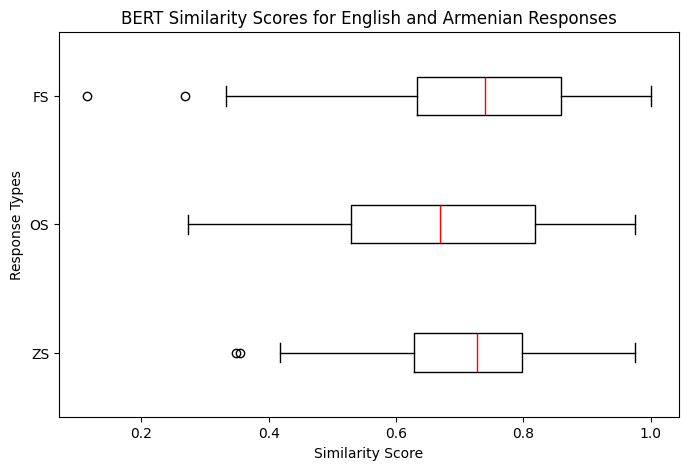

In [18]:
# Boxplot of BERT Similarity Scores for English and Armenian Responses English instruction
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_ZS'], df['sim_response_OS'], df['sim_response_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_web_1.png')
plt.show()

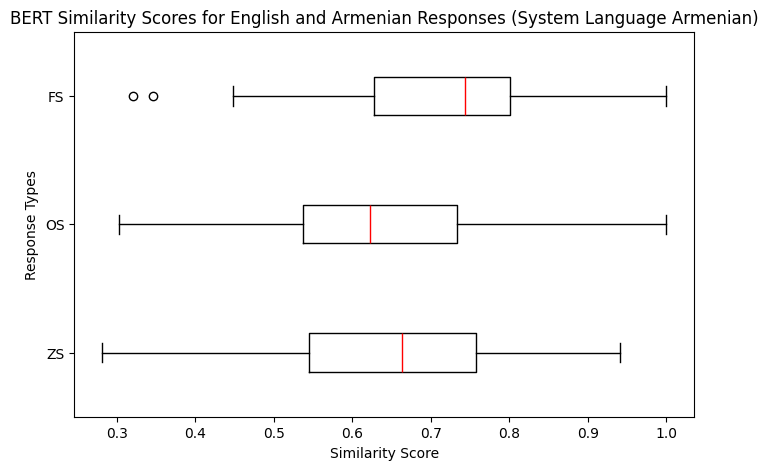

In [19]:
# Boxplot of BERT Similarity Scores for English and Armenian Responses Armenian instruction
plt.figure(figsize=(8, 5))
plt.boxplot([df['sim_response_arm_sys_ZS'], df['sim_response_arm_sys_OS'], df['sim_response_arm_sys_FS']],
            labels=['ZS', 'OS', 'FS'], vert=False,
            medianprops=dict(color='red')) 
plt.title('BERT Similarity Scores for English and Armenian Responses (System Language Armenian)')
plt.xlabel('Similarity Score')
plt.ylabel('Response Types')
plt.savefig('bert_score_web_2.png')
plt.show()

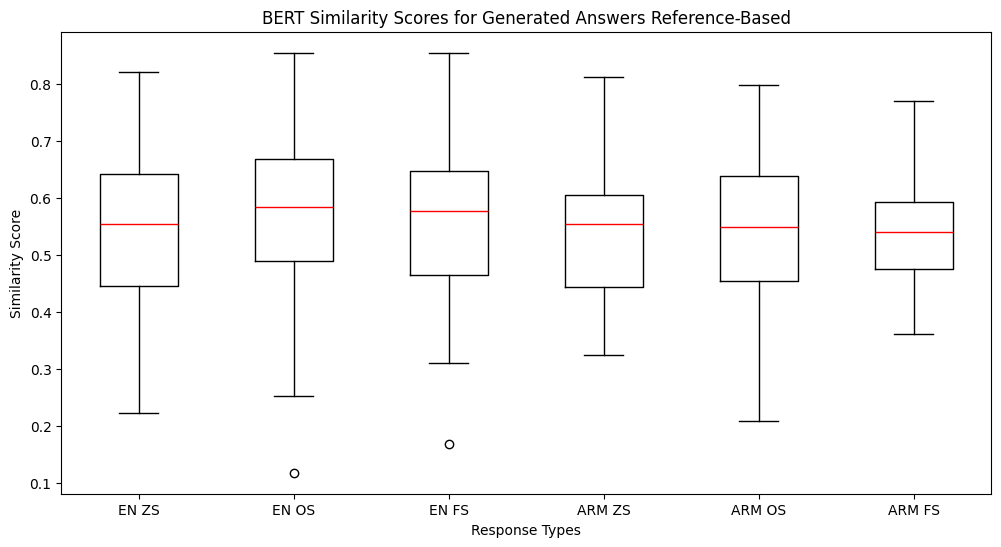

In [20]:
# Boxplot of BERT Similarity Scores for Generated Answers Reference-Based
plt.figure(figsize=(12, 6))
plt.boxplot([df['sim_response_en_reference_ZS'],
    df['sim_response_en_reference_OS'],
    df['sim_response_en_reference_FS'],
    df['sim_response_arm_reference_ZS'],
    df['sim_response_arm_reference_OS'],
    df['sim_response_arm_reference_FS']], 
    labels=['EN ZS', 'EN OS', 'EN FS', 'ARM ZS', 'ARM OS', 'ARM FS'],
    vert=True,
    medianprops=dict(color='red')  
)

plt.title('BERT Similarity Scores for Generated Answers Reference-Based')
plt.xlabel('Response Types')
plt.ylabel('Similarity Score')
plt.savefig('bert_score_web_3.png')
plt.show()


# Similarity Statistics

In [22]:
english_responses = ['sim_response_ZS', 'sim_response_OS', 'sim_response_FS']
armenian_sys_language = ['sim_response_arm_sys_ZS', 'sim_response_arm_sys_OS', 'sim_response_arm_sys_FS']
reference_based = ['sim_response_en_reference_ZS', 'sim_response_en_reference_OS', 'sim_response_en_reference_FS',
                   'sim_response_arm_reference_ZS', 'sim_response_arm_reference_OS', 'sim_response_arm_reference_FS']

# Generate descriptive statistics
english_stats = df[english_responses].describe()
armenian_sys_stats = df[armenian_sys_language].describe()
reference_based_stats = df[reference_based].describe()

# Print the statistics to review them
print("English-Armenian Similarity Statistics:")
print(english_stats)
print("\nEnglish-Armenian Similarity Statistics (Sys lang Arm):")
print(armenian_sys_stats)
print("\nReference-Based Responses Statistics:")
print(reference_based_stats)

English-Armenian Similarity Statistics:
       sim_response_ZS  sim_response_OS  sim_response_FS
count        50.000000        50.000000        50.000000
mean          0.708007         0.669450         0.720974
std           0.149083         0.181447         0.182897
min           0.348889         0.272943         0.114640
25%           0.627854         0.528907         0.633607
50%           0.726563         0.668526         0.739867
75%           0.797184         0.818230         0.859432
max           0.975884         0.975884         1.000000

English-Armenian Similarity Statistics (Sys lang Arm):
       sim_response_arm_sys_ZS  sim_response_arm_sys_OS  \
count                50.000000                50.000000   
mean                  0.650056                 0.625845   
std                   0.161299                 0.166383   
min                   0.281461                 0.302871   
25%                   0.545068                 0.536822   
50%                   0.662684       